In [82]:
# Import packages
import h5py
import numpy as np

import sigpy as sp
from sigpy import backend, linop, prox, util
from sigpy.alg import (PowerMethod, GradientMethod,
                       ConjugateGradient, PrimalDualHybridGradient)
import sigpy.plot as pl
import matplotlib.pyplot as plt
import sys
import os

%matplotlib inline
#where to find the file cfl.py
cflpath = "/home/vroeloffs/reco/t2shuffling-recon-intel/bart/python"
sys.path.append(os.path.abspath(cflpath))
import cfl

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#read dataset: brain dataset
h5_dataset_brain = h5py.File('rawdata_brain_radial_96proj_12ch.h5', 'r')

h5_dataset_rawdata_name = list(h5_dataset_brain.keys())[0]
h5_dataset_trajectory_name = list(h5_dataset_brain.keys())[1]

trajectory = h5_dataset_brain.get(h5_dataset_trajectory_name).value
rawdata = h5_dataset_brain.get(h5_dataset_rawdata_name).value

gpu_number = 1

coor = trajectory[:2,:,:].transpose((1,2,0))
coor = sp.backend.to_device(coor,gpu_number)
rawdata_brain = rawdata[0,:,:,:].transpose((2,0,1))
rawdata_brain = sp.backend.to_device(rawdata_brain,gpu_number)

In [41]:
#generating coil sensitivity profiles
image = cfl.readcfl("img_igrid_brain")
image_sos = sp.util.rss(image,3)
sens_maps = image[:,:,0,:]/image_sos
sens_maps_t = sens_maps.transpose((2,0,1))
sens_maps_t = sp.backend.to_device(sens_maps_t,gpu_number)

In [42]:
#Building the SENSE operator using nuFFT
S = sp.linop.Multiply((1,300,300),sens_maps_t)
NUFFT = sp.linop.NUFFT((12,300,300),coor)
Operator = NUFFT*S

In [154]:
# Build a sigpy app that takes a referenz image and computes difference in each iteration
class LinearLeastSquares_ref(sp.app.LinearLeastSquares):
    def __init__(self, A, y, x=None, proxg=None,
                 lamda=0, G=None, g=None, R=None, mu=0, z=0,
                 alg_name=None, max_iter=100,
                 P=None, alpha=None, max_power_iter=30, accelerate=True,
                 tau=None, sigma=None,
                 save_objective_values=True, show_pbar=True, reference_image=None):
        self.A = A
        self.y = y
        self.x = x
        self.proxg = proxg
        self.lamda = lamda
        self.G = G
        self.g = g
        self.R = R
        self.mu = mu
        self.z = z
        self.alg_name = alg_name
        self.max_iter = max_iter
        self.P = P
        self.alpha = alpha
        self.max_power_iter = max_power_iter
        self.accelerate = accelerate
        self.tau = tau
        self.sigma = sigma
        self.save_objective_values = save_objective_values
        self.show_pbar = show_pbar
        self.reference_image = reference_image
        
        self.y_device = backend.get_device(y)
        if self.x is None:
            with self.y_device:
                self.x = self.y_device.xp.zeros(A.ishape, dtype=y.dtype)

        self.x_device = backend.get_device(self.x)
        self._get_alg()
        
        if self.save_objective_values:
            self.objective_values = []
            
        if self.reference_image is not None:
            self.diff_to_reference = []

    def get_diff_to_reference(self):
        with self.y_device:
            r = self.x - self.reference_image
            diff = self.y_device.xp.linalg.norm(r)
        return util.asscalar(diff)
            
    def _summarize(self):
        if self.save_objective_values:
            self.objective_values.append(self.objective())
            
        if self.reference_image is not None:
            self.diff_to_reference.append(self.get_diff_to_reference())
            
        if self.show_pbar:
            if self.save_objective_values:
                self.pbar.set_postfix(
                    obj='{0:.2E}'.format(self.objective_values[-1]))
            else:
                self.pbar.set_postfix(resid='{0:.2E}'.format(self.alg.resid))            
            
    def _post_update(self):

        return
        



In [161]:
s = LinearLeastSquares_ref(Operator,rawdata_brain,max_iter=10)
img_rec_iter10 = s.run()
img_rec_iter10_gpu = sp.backend.to_device(img_rec_iter10,gpu_number)
s = LinearLeastSquares_ref(Operator,rawdata_brain,max_iter=100,reference_image=img_rec_iter10_gpu)
img_rec_now = s.run()






















LinearLeastSquares_ref:   0%|          | 0/10 [00:00<?, ?it/s]




















LinearLeastSquares_ref:   0%|          | 0/10 [00:00<?, ?it/s, obj=1.05E-03]




















LinearLeastSquares_ref:  10%|█         | 1/10 [00:00<00:00, 20.72it/s, obj=1.05E-03]




















LinearLeastSquares_ref:  10%|█         | 1/10 [00:00<00:00, 10.49it/s, obj=6.24E-04]




















LinearLeastSquares_ref:  20%|██        | 2/10 [00:00<00:00, 20.53it/s, obj=6.24E-04]




















LinearLeastSquares_ref:  20%|██        | 2/10 [00:00<00:00, 13.53it/s, obj=5.88E-04]




















LinearLeastSquares_ref:  30%|███       | 3/10 [00:00<00:00, 20.10it/s, obj=5.88E-04]




















LinearLeastSquares_ref:  30%|███       | 3/10 [00:00<00:00, 20.10it/s, obj=5.88E-04]




















LinearLeastSquares_ref:  30%|███       | 3/10 [00:00<00:00, 20.10it/s, obj=5.78E-04]




















LinearLeastSquares_ref:  40%|████      | 4/10 [00:00<00:00, 20.1

LinearLeastSquares_ref:   9%|▉         | 9/100 [00:00<00:04, 19.82it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  10%|█         | 10/100 [00:00<00:04, 19.82it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  10%|█         | 10/100 [00:00<00:04, 19.82it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  11%|█         | 11/100 [00:00<00:04, 19.87it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  11%|█         | 11/100 [00:00<00:04, 19.87it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  11%|█         | 11/100 [00:00<00:04, 19.87it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  12%|█▏        | 12/100 [00:00<00:04, 19.87it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  12%|█▏        | 12/100 [00:00<00:04, 19.87it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  13%|█▎        | 13/100 [00:00<00:04, 19.87it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  13%|█▎       

LinearLeastSquares_ref:  29%|██▉       | 29/100 [00:01<00:03, 19.10it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  30%|███       | 30/100 [00:01<00:03, 19.20it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  30%|███       | 30/100 [00:01<00:03, 19.20it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  30%|███       | 30/100 [00:01<00:03, 19.20it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  31%|███       | 31/100 [00:01<00:03, 19.20it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  31%|███       | 31/100 [00:01<00:03, 19.20it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  32%|███▏      | 32/100 [00:01<00:03, 19.20it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  32%|███▏      | 32/100 [00:01<00:03, 19.20it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  33%|███▎      | 33/100 [00:01<00:03, 19.94it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  33%|███▎    

LinearLeastSquares_ref:  49%|████▉     | 49/100 [00:02<00:02, 17.98it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  49%|████▉     | 49/100 [00:02<00:02, 17.98it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  49%|████▉     | 49/100 [00:02<00:02, 17.98it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  50%|█████     | 50/100 [00:02<00:02, 17.98it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  50%|█████     | 50/100 [00:02<00:02, 17.98it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  51%|█████     | 51/100 [00:02<00:02, 17.03it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  51%|█████     | 51/100 [00:02<00:02, 17.03it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  51%|█████     | 51/100 [00:02<00:02, 17.03it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  52%|█████▏    | 52/100 [00:02<00:02, 17.03it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  52%|█████▏  

LinearLeastSquares_ref:  68%|██████▊   | 68/100 [00:03<00:01, 18.97it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  69%|██████▉   | 69/100 [00:03<00:01, 19.51it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  69%|██████▉   | 69/100 [00:03<00:01, 19.51it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  69%|██████▉   | 69/100 [00:03<00:01, 19.51it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  70%|███████   | 70/100 [00:03<00:01, 19.51it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  70%|███████   | 70/100 [00:03<00:01, 19.51it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  71%|███████   | 71/100 [00:03<00:01, 18.97it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  71%|███████   | 71/100 [00:03<00:01, 18.97it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  71%|███████   | 71/100 [00:03<00:01, 18.97it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  72%|███████▏

LinearLeastSquares_ref:  88%|████████▊ | 88/100 [00:04<00:00, 18.83it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  88%|████████▊ | 88/100 [00:04<00:00, 18.83it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  89%|████████▉ | 89/100 [00:04<00:00, 19.23it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  89%|████████▉ | 89/100 [00:04<00:00, 19.23it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  89%|████████▉ | 89/100 [00:04<00:00, 19.23it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  90%|█████████ | 90/100 [00:04<00:00, 19.23it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  90%|█████████ | 90/100 [00:04<00:00, 19.23it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  91%|█████████ | 91/100 [00:04<00:00, 19.23it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  91%|█████████ | 91/100 [00:04<00:00, 19.23it/s, obj=5.64E-04]




















LinearLeastSquares_ref:  92%|████████

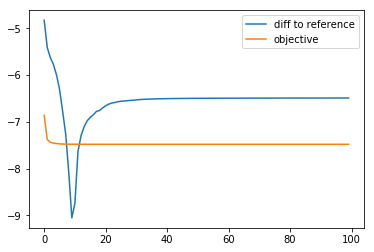

In [162]:
plt.plot(np.log(s.diff_to_reference),label='diff to reference')
plt.plot(np.log(s.objective_values),label='objective')
plt.legend()
plt.show()

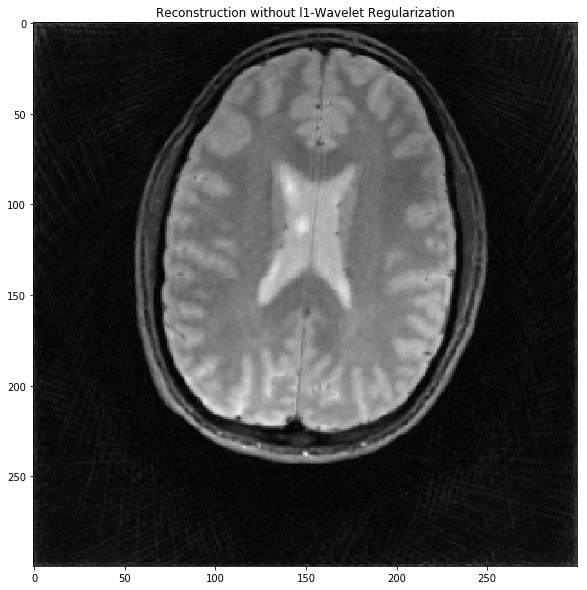

In [48]:
img_rec_now = sp.backend.to_device(img_rec_now)
im_abs_recon_now = abs(img_rec_now[0,:,:])
plt.figure(figsize=(20,10))
plt.title("SENSE Reconstruction")
plt.imshow(im_abs_recon_now[::-1,:],cmap='gray')
plt.show()


LinearLeastSquares:  14%|█▍        | 14/100 [00:00<00:10,  8.17it/s, resid=6.24E-03]


LinearLeastSquares:  55%|█████▌    | 55/100 [00:01<00:01, 30.41it/s, resid=9.89E-04]


LinearLeastSquares:  96%|█████████▌| 96/100 [00:03<00:00, 31.06it/s, resid=3.61E-04]


LinearLeastSquares: 100%|██████████| 100/100 [00:03<00:00, 29.26it/s, resid=3.41E-04]

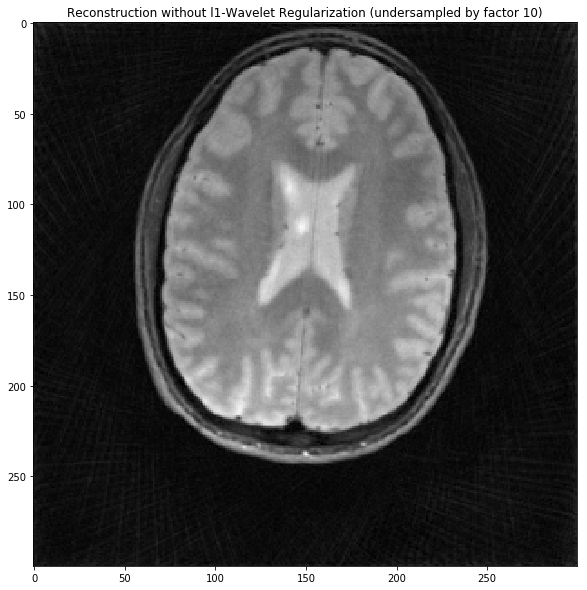

In [18]:
# Subsample of the radial data
#L_2 Normalization
lamda_l2 = 0.1
proxg_l2 = sp.prox.L2Reg((1,300,300),lamda_l2)
coor_subsample_2 = coor[:,::1,:]
rawdata_brain_2 = rawdata_brain[:,:,::1]
# pl.ScatterPlot(coor_subsample_2)
S_2 = sp.linop.Multiply((1,300,300),sens_maps_t)
NUFFT_2 = sp.linop.NUFFT((12,300,300),coor_subsample_2)
Operator_2 = NUFFT_2*S_2
img_rec_now_2 = sp.app.LinearLeastSquares(Operator_2,rawdata_brain_2,proxg=proxg_l2,max_iter=100).run()
img_rec_now_2 = sp.backend.to_device(img_rec_now_2)
im_abs_recon_now_2 = abs(img_rec_now_2[0,:,:])
plt.figure(figsize=(20,10))
plt.title("Reconstruction without l1-Wavelet Regularization (undersampled by factor %d)"%10)
plt.imshow(im_abs_recon_now_2[::-1,:],cmap='gray')
plt.show()